In [44]:
import spacy
import json
import os
import numpy as np
import networkx as nx
import pandas as pd
from pprint import pprint
from spacy import displacy
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
def load_json_files(path_to_json):
    ####################
    #print(path_to_json)
    ####################
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    #######################
    #print(json_files[3:4])
    #######################
    json_objects = list()
    for index, js in enumerate(json_files):
        #######################
        #print(index, ": ", js)
        #######################
        with open(os.path.join(path_to_json, js)) as json_file:
            json_objects.append(json.load(json_file))
    #####################
    #pprint(json_objects)
    #####################
    
    del json_objects[3]
    del json_objects[28-1]
    del json_objects[75-2]
    del json_objects[114-3]
    del json_objects[175-4]
    del json_objects[238-5]
    del json_objects[261-6]
    del json_objects[279-7]
    del json_objects[327-8]
    del json_objects[364-9]
    del json_objects[374-10]
    del json_objects[402-11]
    del json_objects[406-12]
    
    return json_objects#[:1]
##### index number 3, 28, 75, 114, 175, 238, 261, 279, 327, 364, 374, 402, 406 has denotation_span = None

In [46]:
stopwords_en = None
with open("stopwords-en.txt", "rt", encoding="utf-8-sig") as infile:
    stopwords_en = json.load(infile)["en"]
#print(stopwords_en)

In [47]:
nlp = spacy.load("en")

In [48]:
#denotations vs global id dictionary
span_g_id = dict()

In [49]:
def generate_token_denotation(denotation, denotation_span):
    
    token_denotation_info = dict()

    token_denotation_info = {"span" : denotation_span, "obj" : denotation["obj"],"tag" : dict()}#, "relation" : json_object_relations}
    
    #getting tag of tokens in denotation_span(disease or gene or expression)
    for token in denotation_span:
        if str(token) in token_denotation_info["tag"]:
            if str(token.tag_) in token_denotation_info["tag"][str(token)]:
                token_denotation_info["tag"][str(token)][str(token.tag_)] += 1
                ##
#                print(token_denotation_info[span_g_id[denotation_span_str]]["tag"][token])
            else:
                token_denotation_info["tag"].update({str(token) : {str(token.tag_) : 1}})
        else:
            token_denotation_info["tag"].update({str(token) : {str(token.tag_) : 1}})

    return token_denotation_info;

In [50]:
def update_token_denotation_infos(token_denotation_infos, denotation_span):
    denotation_span_str = str(denotation_span)
    for token in denotation_span:                
        if str(token) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"]:
            if str(token.tag_) in token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)]:
                token_denotation_infos[span_g_id[denotation_span_str]]["tag"][str(token)][str(token.tag_)] += 1
                ##
#               print(token_denotation_infos[span_g_id[denotation_span_str]]["tag"][token])
            else:
                token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
        else:
            token_denotation_infos[span_g_id[denotation_span_str]]["tag"].update({str(token) : {str(token.tag_) : 1}})
    return token_denotation_infos

In [51]:
def get_sentences_containing_denotations(sentence_with_denotation, text, denotation, no_pre_post):
    words = list()
    for sent in text.sents:
        if(denotation.start >= sent.start and denotation.end < sent.end):
            #print(sent)
            if(denotation.start != sent.start):
                pr_w = text[denotation.start-1]
                for i in range(0,no_pre_post):
                    if(pr_w.i-1 >= sent.start):
                        while(pr_w.string.strip() in stopwords_en):
                            pr_w = text[pr_w.i-1]
                        words.append(pr_w.string.strip())
                        pr_w = text[pr_w.i-1]
            
            words.append(denotation.string.strip())
            
            if(denotation.end != sent.end):
                ps_w = text[denotation.end]
                for i in range(0,no_pre_post):
                    if(ps_w.i+1 < sent.end):
                        while(ps_w.string.strip() in stopwords_en):
                            ps_w = text[ps_w.i+1]
                        words.append(ps_w.string.strip())
                        ps_w = text[ps_w.i+1]
            
            if(sent.string.strip() in sentence_with_denotation):
                sentence_with_denotation[sent.string.strip()].append(denotation.string.strip())
            else:
                sentence_with_denotation[sent.string.strip()] =[denotation.string.strip()]
    return sentence_with_denotation, words

In [52]:
def generate_token_info(json_objects, no_pre_post):
    
    token_denotation_infos = dict()
    token_relation_infos = dict()
    sentences_by_article = dict()
    words_by_article = dict()
    
    #count for gene disease and expression
    gene_count = 1
    disease_count = 1
    expression_count = 1
    #regulation_count = 1
    
    #iterate through the json objects
    for jindex,json_object in enumerate(json_objects): 
        json_object_text = json_object["text"]
        json_object_denotations = json_object["denotations"]
        json_object_relations = json_object["relations"]
        json_object_pubmed_id = json_object["sourceid"]
        
        ##
        #pprint(json_object_relations)
        #print()
        
        #parsing text using spacy
        parsed_text = nlp(json_object_text)
        
        #local and global id dictionary for each json object
        lg_id = dict()
        sentence_with_denotation = dict()
        words_by_article[json_object_pubmed_id] = dict()
        
        #iterate through denotation within json object
        for index,denotation in enumerate(json_object_denotations):
            denotation_start = denotation["span"]["begin"]
            denotation_end = denotation["span"]["end"]
            denotation_span = parsed_text.char_span(denotation_start, denotation_end)
            denotation_span_str = str(denotation_span)
            
            #print(str(denotation_span.rights))
            
            sentence_with_denotation, words_by_article[json_object_pubmed_id][denotation_span_str] = get_sentences_containing_denotations(sentence_with_denotation, parsed_text, denotation_span, no_pre_post)
            #return
            ##
#             print("[", jindex, "]", denotation, "-> ", denotation_span, " : ", denotation_span_str)
            
            if denotation_span_str in span_g_id:
                token_denotation_infos = update_token_denotation_infos(token_denotation_infos, denotation_span)
                lg_id[denotation["id"]] = span_g_id[denotation_span_str]
            else:
                if ("expression" in denotation["obj"].lower() or "regulation" in denotation["obj"].lower()):
                    key = "e_" + json_object_pubmed_id + "_" + str(expression_count)
                    token_denotation_infos[key] = generate_token_denotation(denotation,denotation_span)
                    #populating span_g_id
                    span_g_id[denotation_span_str] = key
                
                    #populating lg_id
                    lg_id[denotation["id"]] = key
                    expression_count += 1

                elif ("cancer" in denotation["obj"].lower()):
                    key = "d_" + str(disease_count)
                    token_denotation_infos[key] = generate_token_denotation(denotation,denotation_span)
                    #populating span_g_id
                    span_g_id[denotation_span_str] = key
                
                    #populating lg_id
                    lg_id[denotation["id"]] = key
                    disease_count += 1

                elif ("gene" in denotation["obj"].lower()):
                    key = "g_" + str(gene_count)
                    token_denotation_infos[key] = generate_token_denotation(denotation,denotation_span)
                    #populating span_g_id
                    span_g_id[denotation_span_str] = key
                
                    #populating lg_id
                    lg_id[denotation["id"]] = key
                    gene_count += 1
                    
                else:
                    print("EXCEPTION: ", denotation, "-> ", denotation_span)
                    span_g_id[denotation_span_str] = "EXCEPTION"
                    lg_id[denotation["id"]] = "EXCEPTION"
        #return
        sentences_by_article[json_object_pubmed_id] = sentence_with_denotation
        ##
        #print(lg_id)
        #print()

        relations = list()
        for index,relation in enumerate(json_object_relations):
            relations.append({"subj" : lg_id[relation["subj"]], "obj" : lg_id[relation["obj"]], "pred" : relation["pred"]})
        token_relation_infos[json_object_pubmed_id] = relations
##
#     print(span_g_id)
    #pprint(token_denotation_infos)
    #print()
    #pprint(token_relation_infos)
    
    return token_denotation_infos, token_relation_infos, sentences_by_article, words_by_article

In [53]:
path_to_json = "F:/UB/2nd Sem/Basic Projects/Graph Data mining for Gene Cancer relation/CoMAGC-annotations/CoMAGC/"
json_objects = load_json_files(path_to_json)
nodes_info, edges_info, sentences, bag_of_words = generate_token_info(json_objects,3)
print(bag_of_words)

{'10067845': {'LNCaP': ['inhibition', 'growth', 'demonstrate', 'LNCaP', 'cells', '1,25-(OH)2D3', '9-cis'], 'induction': ['preceded', 'mechanism', 'dependent', 'induction', 'AR', 'gene', 'expression'], 'AR gene': ['induction', 'preceded', 'mechanism', 'AR gene', 'expression'], 'expression': ['gene', 'AR', 'induction', 'expression']}, '10216950': {'prostate carcinoma': ['confirmed', 'patients', 'samples', 'prostate carcinoma', 'scored', 'positive', 'expression'], 'positive': ['scored', 'carcinoma', 'prostate', 'positive', 'expression', 'PTI-1', 'normal'], 'expression': ['positive', 'scored', 'carcinoma', 'expression', 'PTI-1', 'normal', 'tissues'], 'PTI-1': ['expression', 'positive', 'scored', 'PTI-1', 'normal', 'tissues', 'blood']}, '10323669': {'stimulate': [')', 'E2', '(', 'stimulate', 'Src', '/', 'p21ras'], 'Src/p21ras/mitogen-activated protein kinase': ['stimulate', ')', 'E2', 'Src/p21ras/mitogen-activated protein kinase', 'pathway', 'breast', 'cancer'], 'breast cancer': ['stimulati

In [54]:
def get_nodes_labels(node_infos):
    nodes = list()
    n_labels = dict()
    for node,info in node_infos.items():
        nodes.append(node)
        n_labels[node] = str(info["span"])
    return nodes, n_labels

def get_edge_labels(edge_infos):
    e_labels = dict()
    for k,edges in edge_infos.items():
        for edge in edges:
            e_labels[(edge["subj"],edge["obj"])] = e_labels.get((edge["subj"],edge["obj"]), edge["pred"]) + "/" + edge["pred"]
    return e_labels

def get_edges_labels_weights():
    labels = get_edge_labels(edges_info)
    e_labels = dict()
    edges = list()
    for key, value in labels.items():
        v_arr = value.split("/")
        v_dict = dict()
        weight = 0
        l = ""
        for x in v_arr:
            v_dict[x] = v_dict.get(x,0) + 1
        k_list = list(v_dict.keys())
        for k, v in v_dict.items():
            if k == k_list[-1]:
                l += str(k) + "*" + str(v)
            else:
                l += str(k) + "*" + str(v) + ", "
            weight += v
        nkey = key + (weight,)
        e_labels[key] = l
        edges.append(nkey)
#         for et, el in e_labels.items():
#             edges.append(et)
            #e_labels[et] = el
    return edges, e_labels

In [55]:
def compute_node_size(min_degree, max_degree, nds):
    node_sizes = list()
    for nd in nds:
        node_sizes.append(list(nd))
                          
    for index,nd in enumerate(node_sizes):
        if nd[1] == 0:
            node_sizes[index][1] = (((max_degree-min_degree)/500)+200)*0.5
        else:
            node_sizes[index][1] = (((max_degree-min_degree)/500)+200)*nd[1]
                          
    return node_sizes

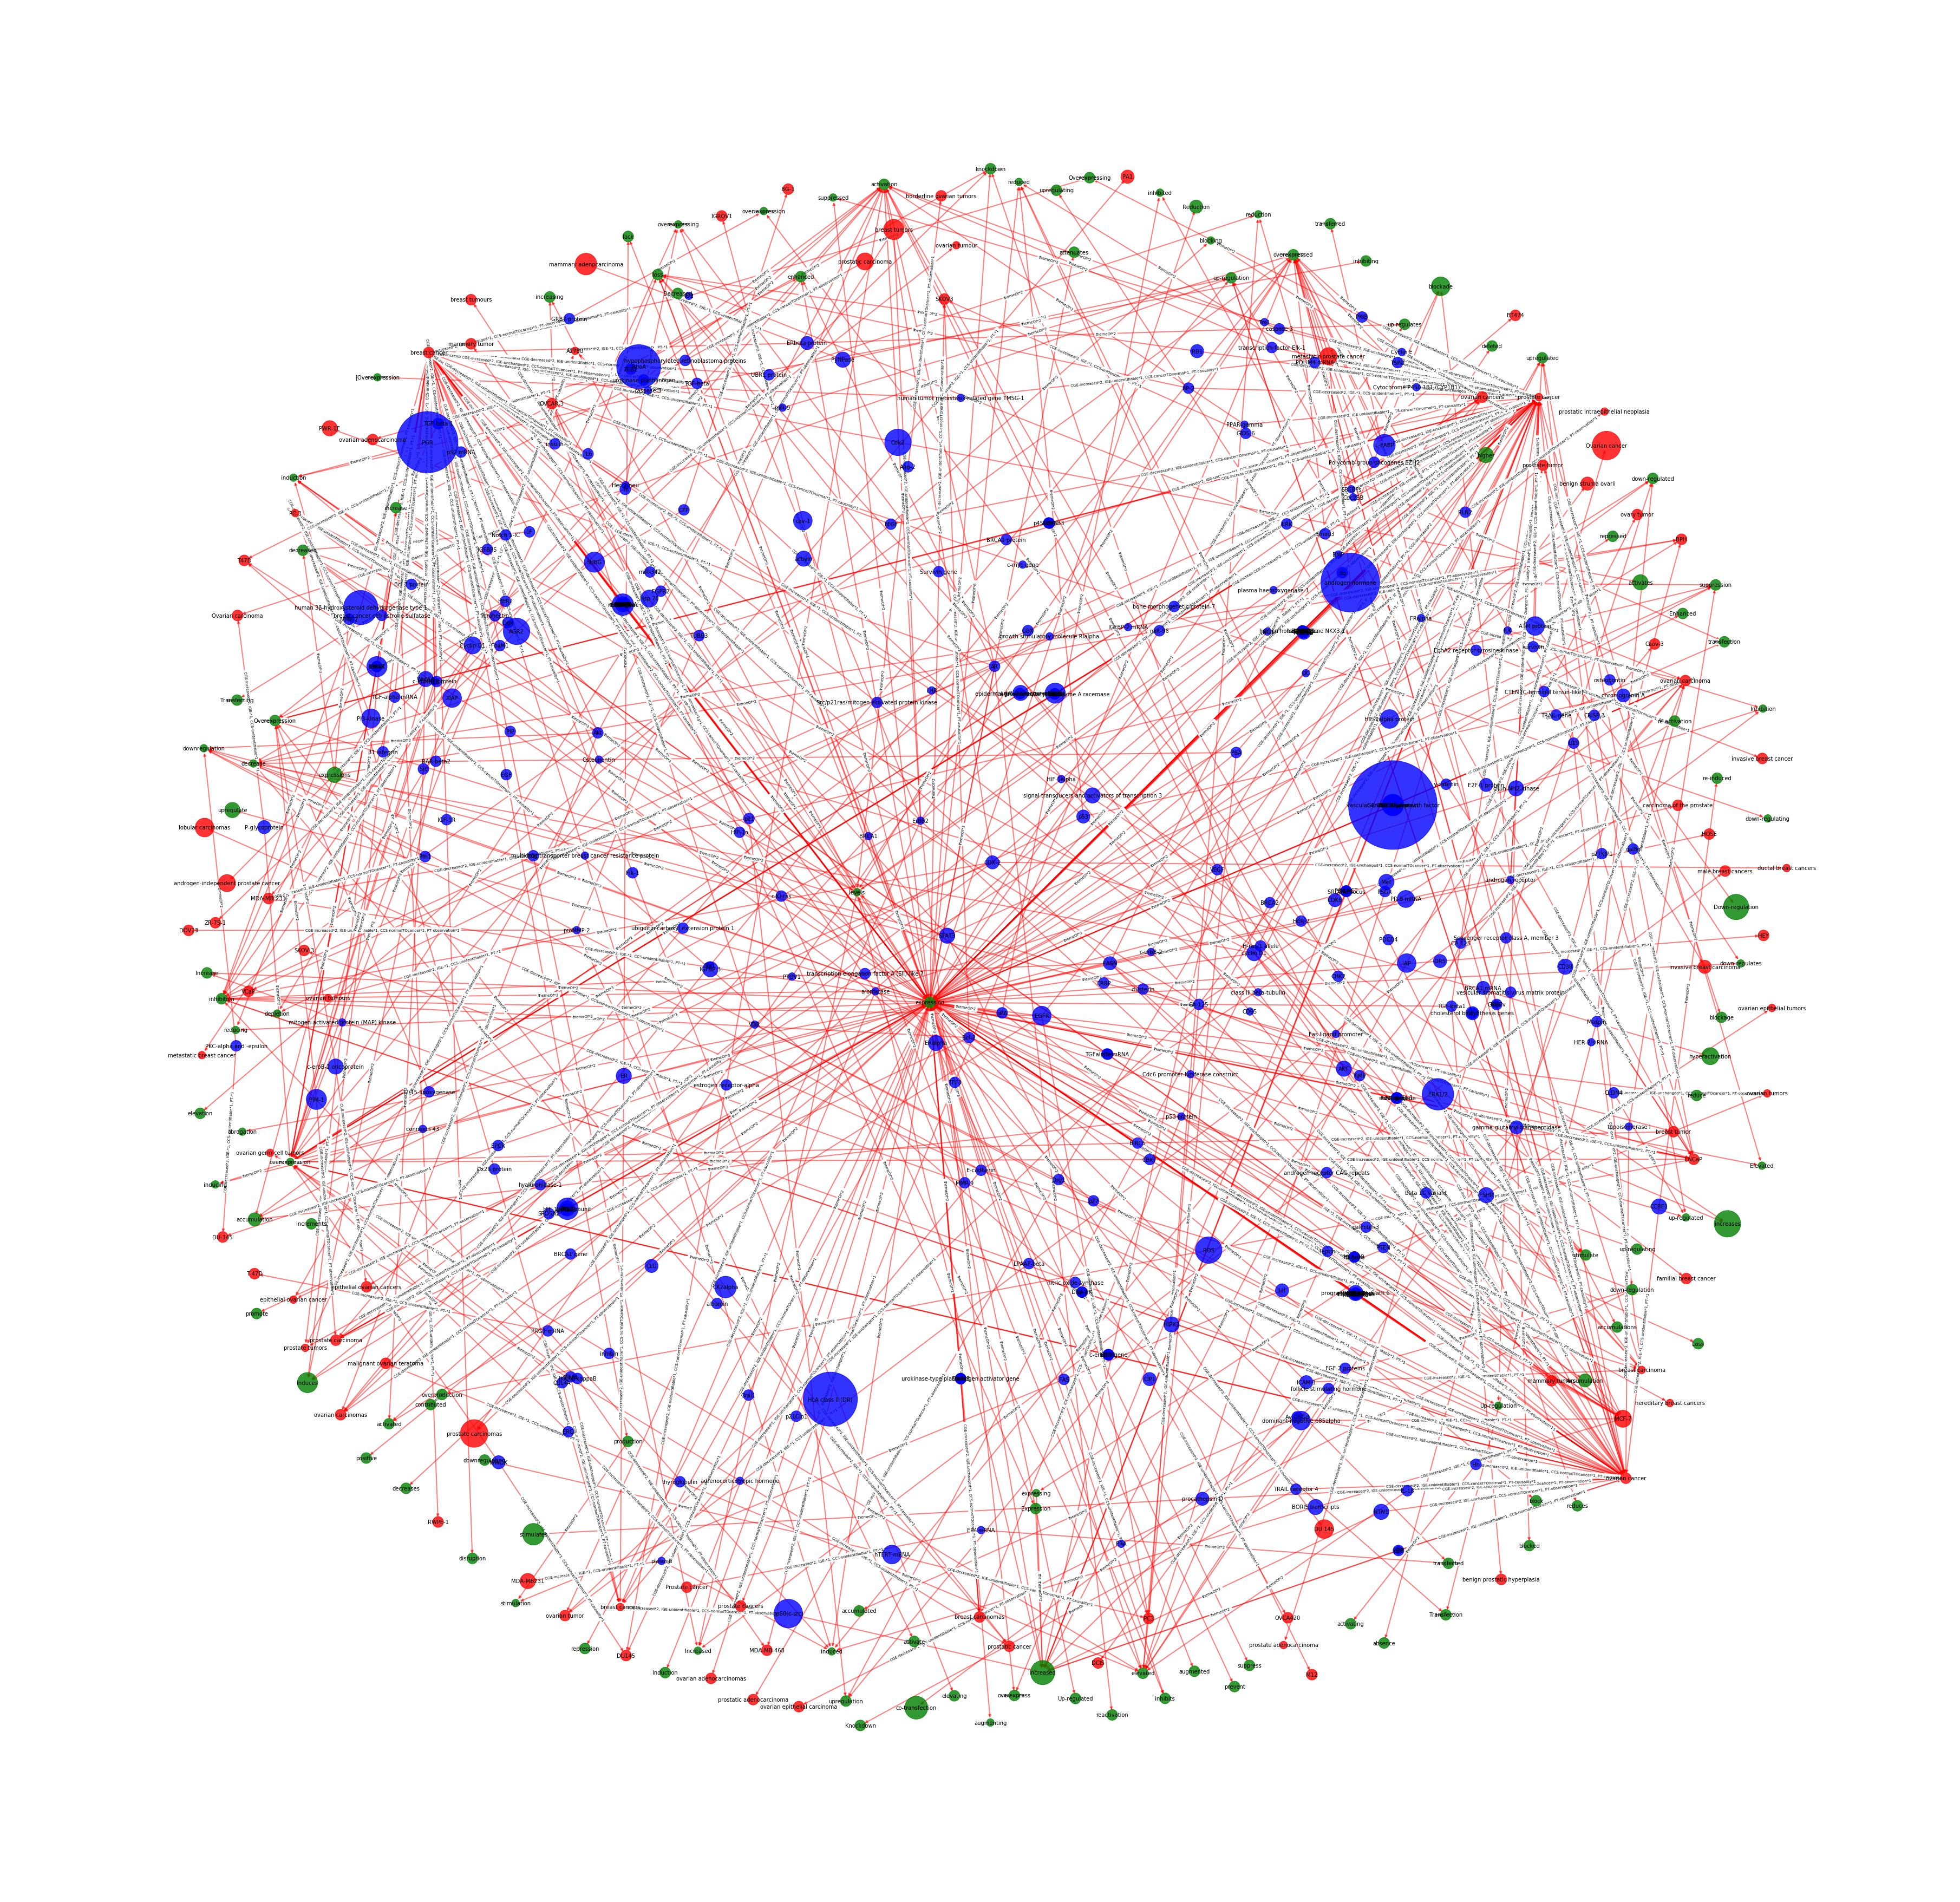

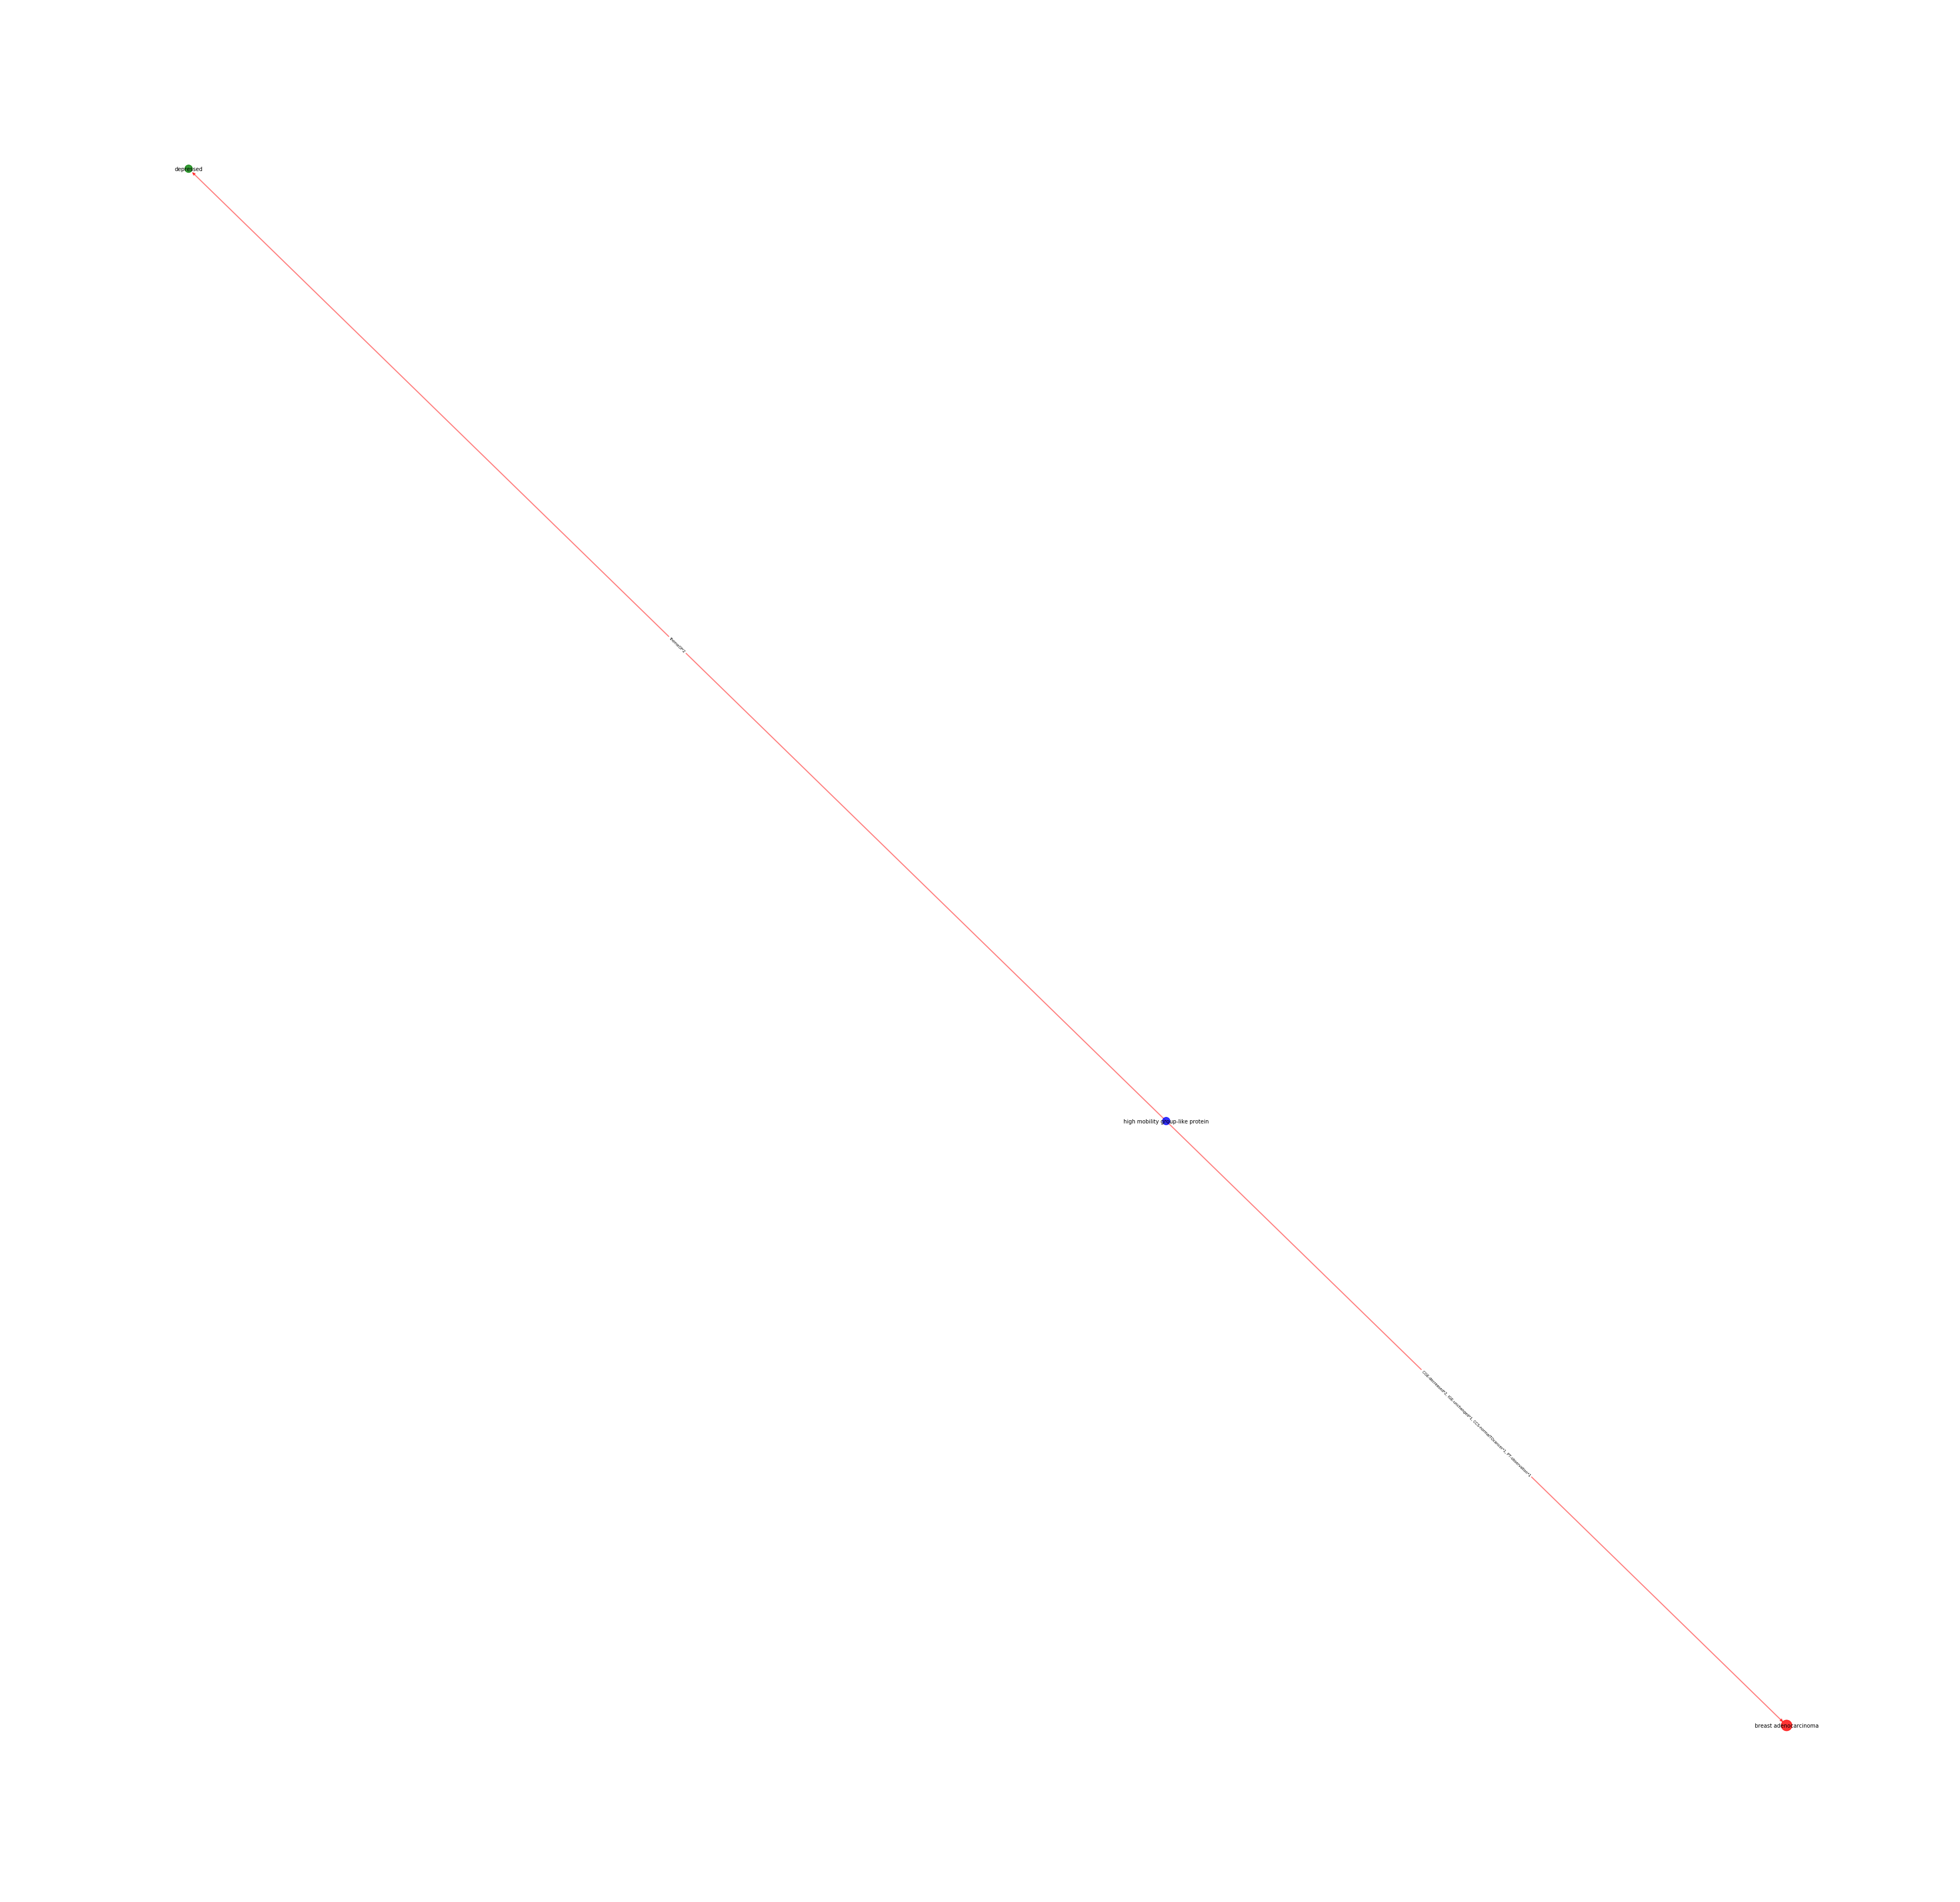

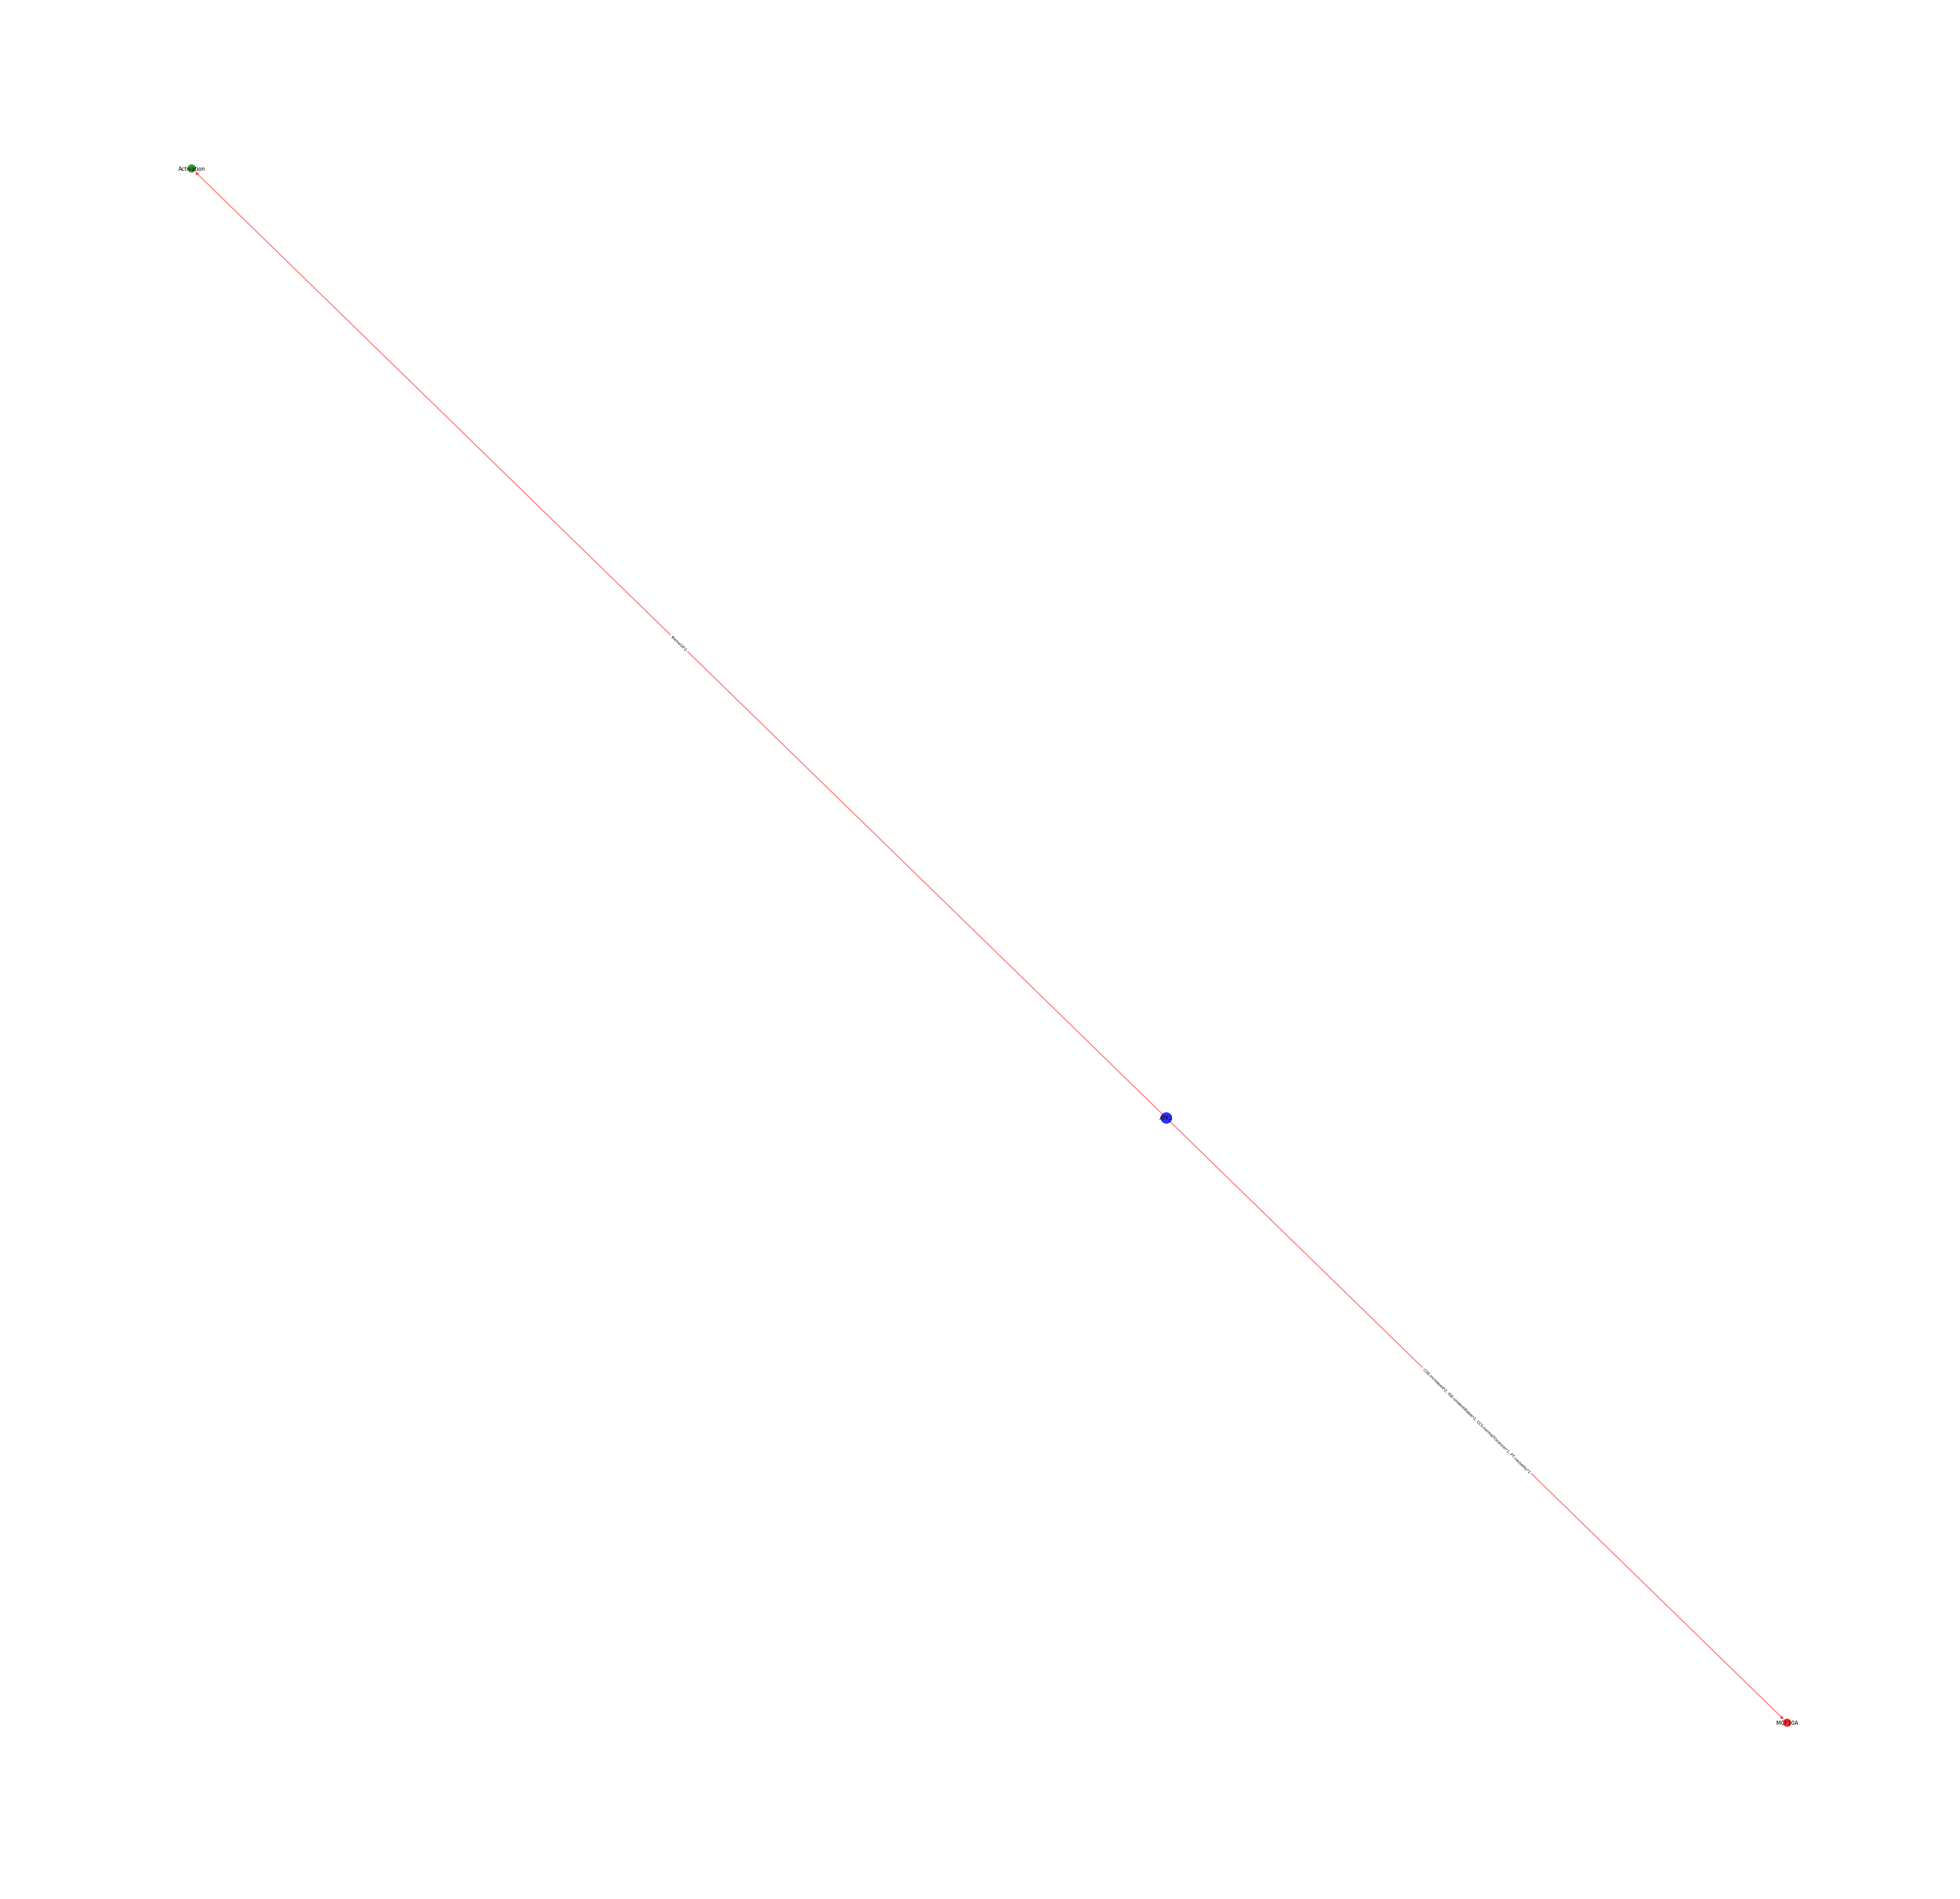

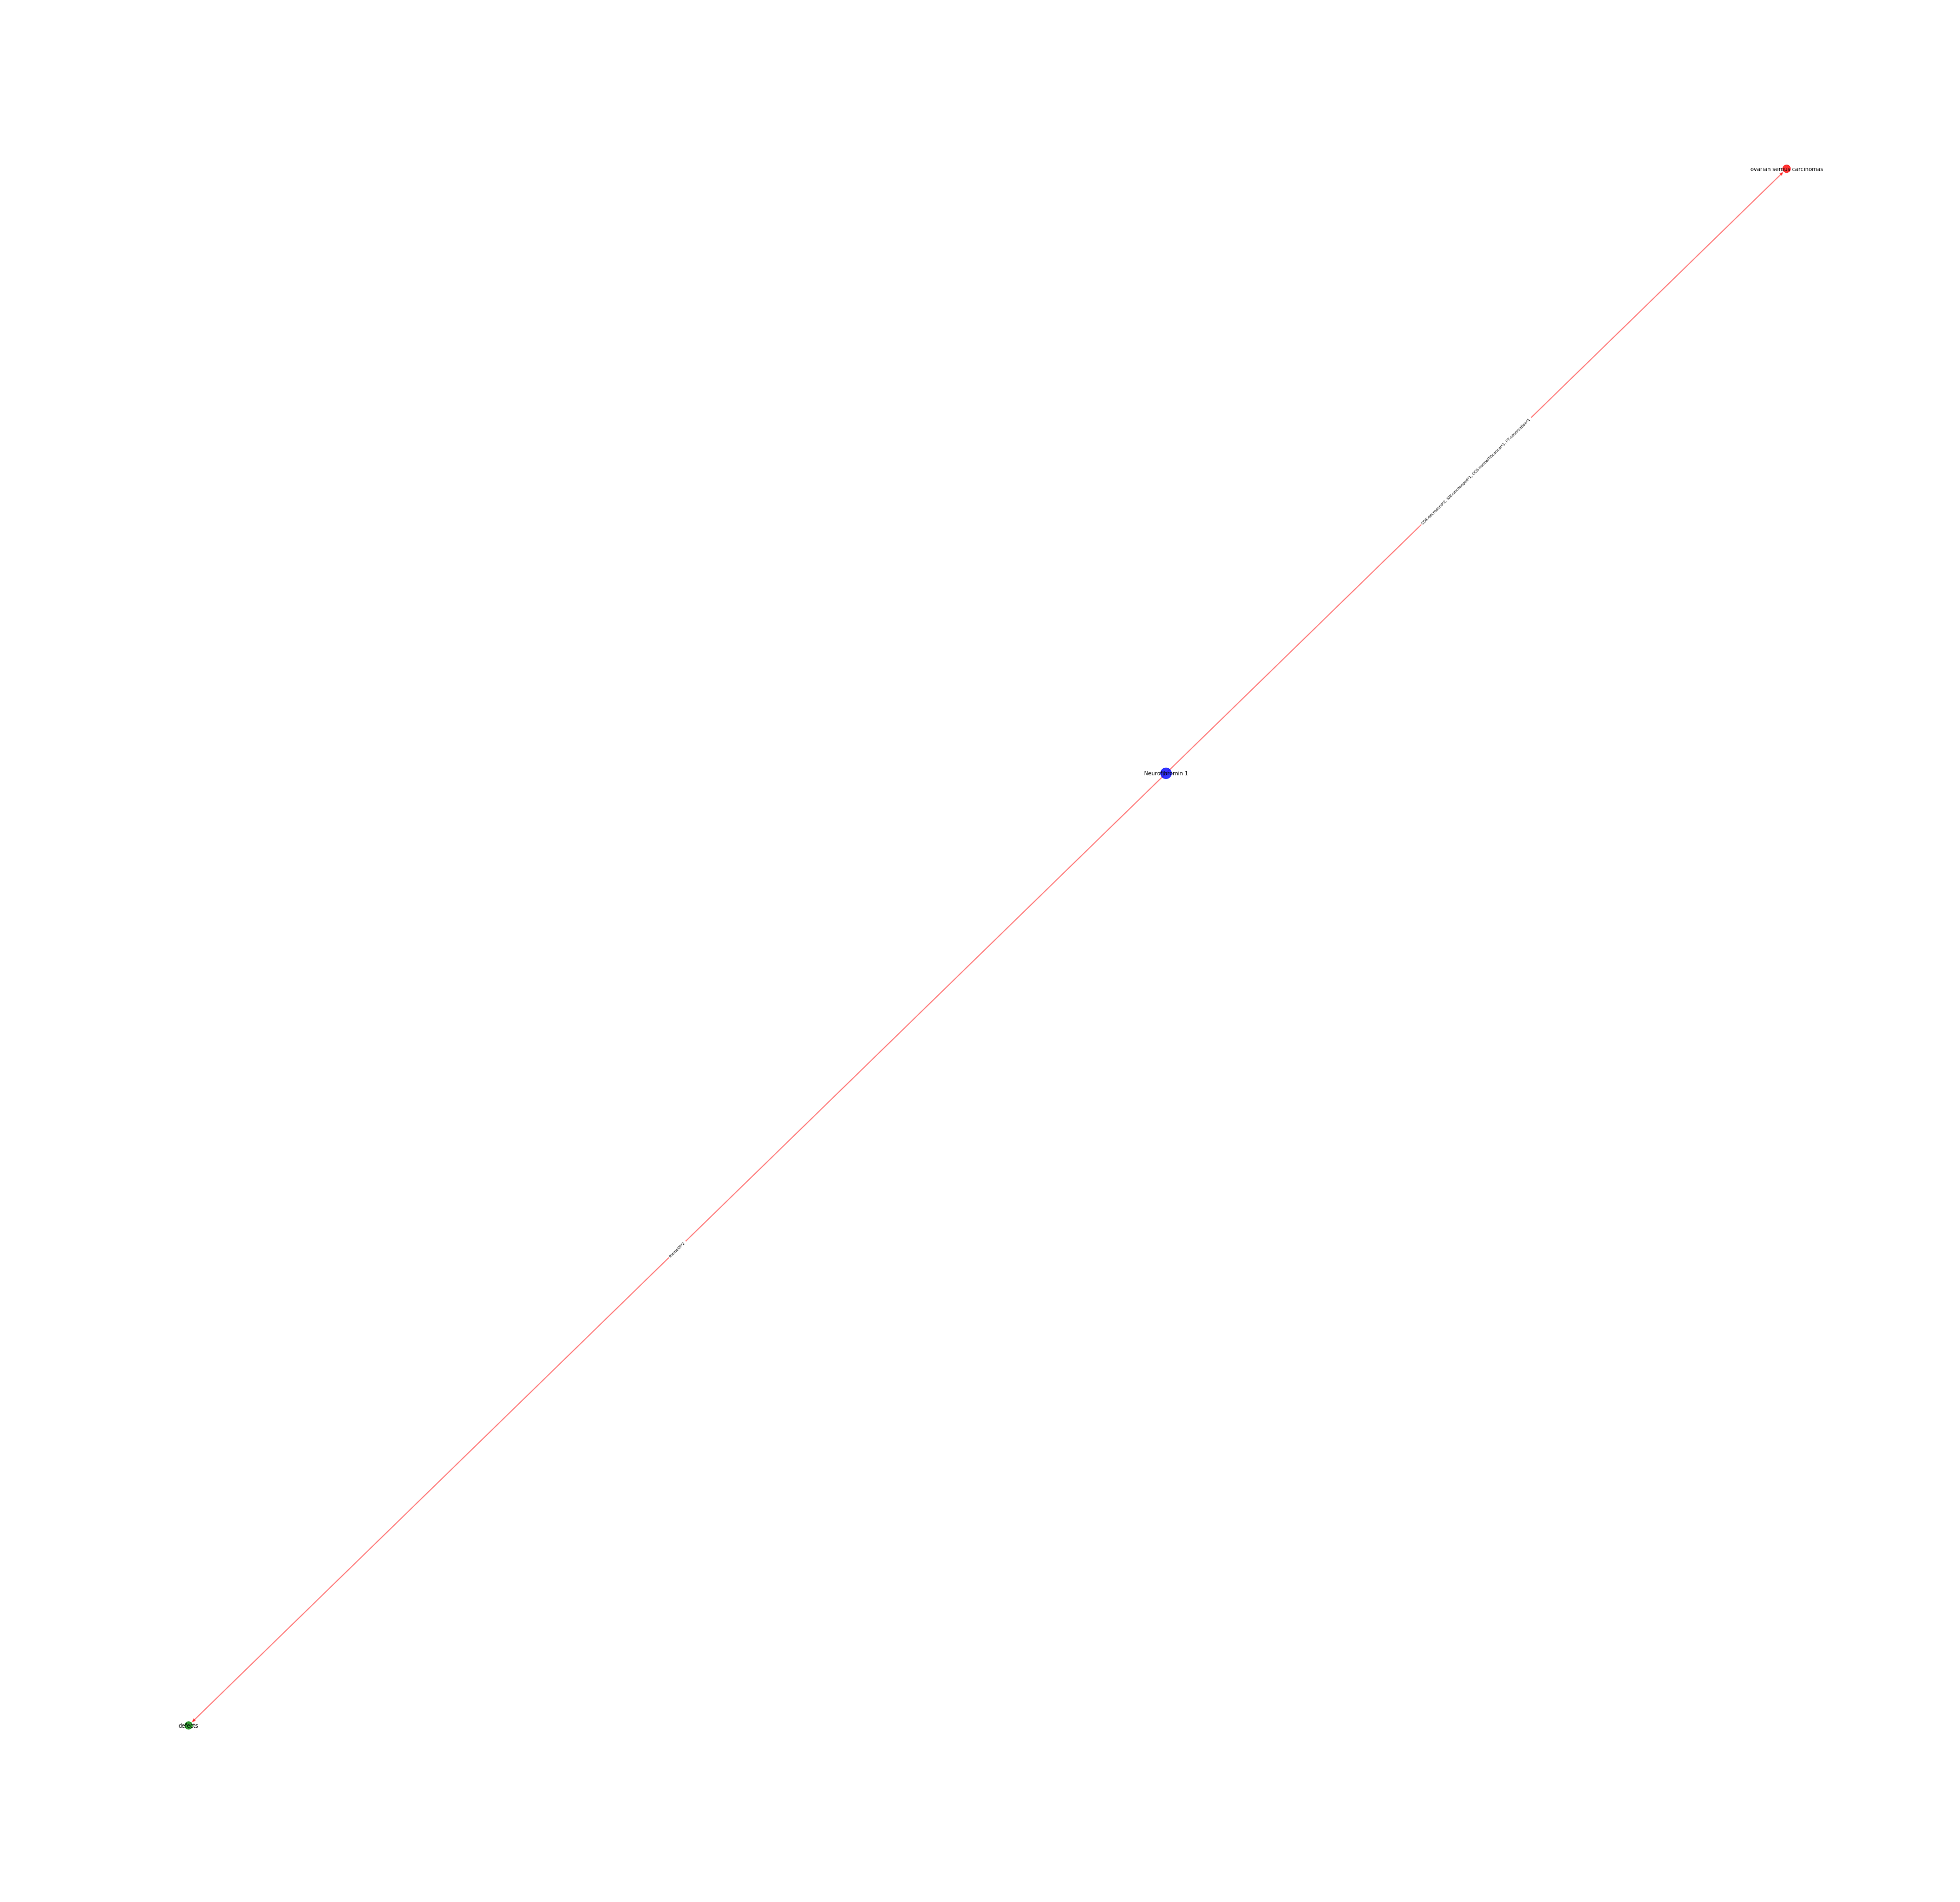

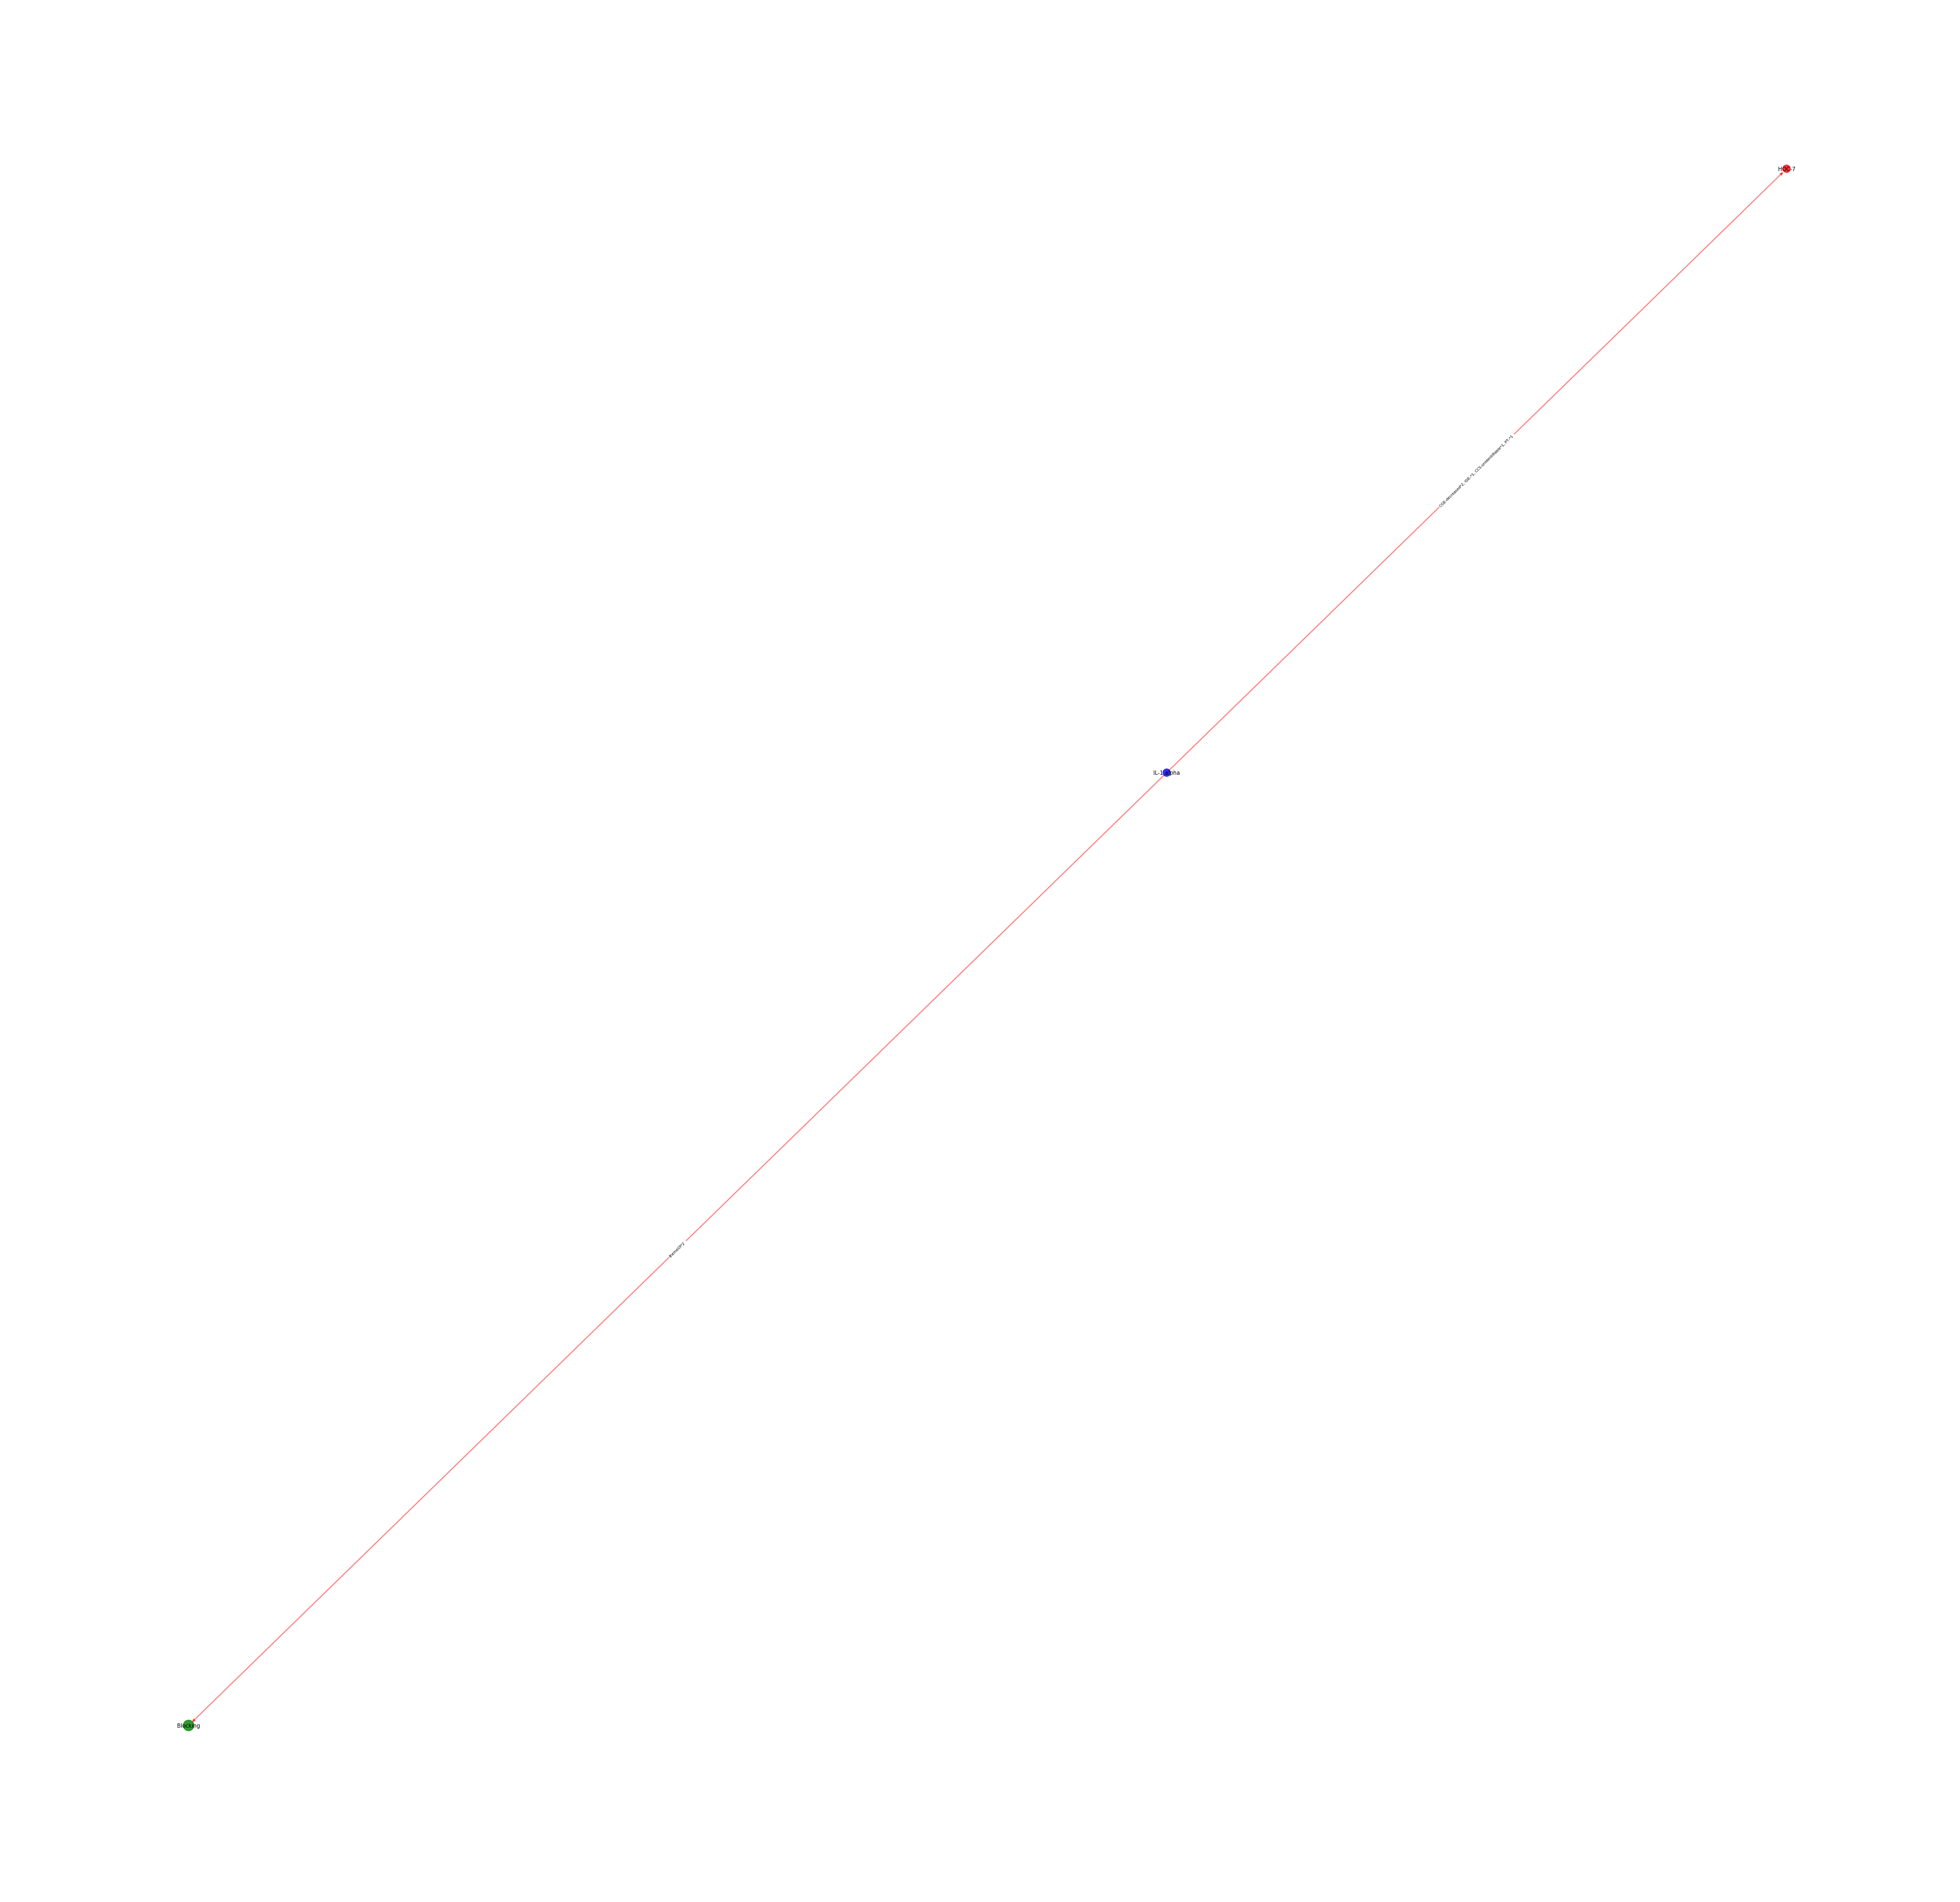

In [56]:
###try outs

# print()
nodes, n_labels = get_nodes_labels(nodes_info)
edges, e_labels = get_edges_labels_weights()

# a = [n for n in nodes if "e_" in n]
# print(a)


def initialize_graph(nodes, edges):
    g = nx.DiGraph()


    g.add_nodes_from(nodes)
    g.add_weighted_edges_from(edges)
    
    return g

def draw_graph (nodes, n_labels, edges, e_labels):
    g = initialize_graph(nodes, edges)
    n_out_degree = g.degree(nodes)
#     n_out_degree = dict(n_out_degree)

    min_pair = min(n_out_degree, key = lambda t: t[1])
    max_pair = max(n_out_degree, key = lambda t: t[1])
###
#     print(min_pair)
#     print(max_pair)

    node_sizes = compute_node_size(min_pair[1], max_pair[1], n_out_degree)
    

    for component in sorted(nx.weakly_connected_component_subgraphs(g), key = len, reverse = True):
    #     print(component.nodes())
        if len(component) < 2:
            continue
        #matplotlib graph size
        plt.figure(1, figsize = (64,64))

        #networkx layout
        pos = nx.spring_layout(component)
        #pos = nx.circular_layout(component)

        #subgraph nodes and labels
        cmp_n_labels = dict((key, value) for key, value in n_labels.items() if key in component.nodes())
        cmp_n_colors = list()
        for key in component.nodes():
            if "g_" in key:
                value = "b"
            elif "d_" in key:
                value = "r"
            else:
                value = "g"
            cmp_n_colors.append(value)
        
        nx.draw_networkx_nodes(component, pos, nodelist = component.nodes(), node_color=cmp_n_colors, 
                               node_size = [v[1] for v in node_sizes if v[0] in component.nodes()], alpha=0.8)
        nx.draw_networkx_labels(component, pos, cmp_n_labels, font_size=10)

        #subgraph edges and labels
        cmp_e_labels = dict((key, value) for key, value in e_labels.items() if key in component.edges())

        nx.draw_networkx_edges(component, pos, edgelist=component.edges(), width=2, alpha=0.5, edge_color='r')
        nx.draw_networkx_edge_labels(component, pos, edge_labels = cmp_e_labels, font_size=7)

        plt.axis('off')
        plt.savefig("test.pdf")
#         break
        plt.show()
        
draw_graph(nodes, n_labels, edges, e_labels)

### ---------------------------------------------------------

In [57]:
text = "Hello, world. Regular expressions are not always the answer."
partitions = text.partition("Hello,")
print(partitions)
pref_words = list(filter(None, partitions[0].split(" ")))
print(pref_words)
print()
if(len(pref_words)>1):
    print("l1: ",pref_words[len(pref_words)-1])
    print("l2: ",pref_words[len(pref_words)-2])
elif(len(pref_words)>0 and pref_words[len(pref_words)-1]):
    print("l1: ",pref_words[len(pref_words)-1])
    
postf_words = list(filter(None, partitions[2].split(" ")))
print(postf_words)
print()
if(len(postf_words)>1):
    print("0: ",postf_words[0])
    print("1: ",postf_words[1])
elif(len(postf_words)>0 and postf_words[0]):
    print("0: ",postf_words[0])

('', 'Hello,', ' world. Regular expressions are not always the answer.')
[]

['world.', 'Regular', 'expressions', 'are', 'not', 'always', 'the', 'answer.']

0:  world.
1:  Regular
